This notebook shows that the continuous and discrete adjoint methods give the same result if no stabilisation is applied.

In [1]:
from firedrake import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import GenericSolveBlock, ProjectBlock

In [2]:
import matplotlib.pyplot as plt
import scipy.interpolate as si

In [3]:
from adapt_utils.case_studies.tohoku.options.options import TohokuInversionOptions
from adapt_utils.misc import gaussian, ellipse

Specify 'optimum' and initial guess

In [4]:
m_opt = 5.0
m_prior = 10.0

Create `Options` object and setup gauges.

In [5]:
level = 0
op = TohokuInversionOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0', '80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())

/home/joe/software/firedrake/src/firedrake/firedrake/parloops.py:130: LoopyWarning: 'lang_version' was not passed to make_function(). To avoid this warning, pass lang_version=(2018, 2) in this invocation. (Or say 'from loopy.version import LOOPY_USE_LANGUAGE_VERSION_2018_2' in the global scope of the calling frame.)
  knl = loopy.make_function(kernel_domains, instructions, kargs, seq_dependencies=True,


Setup timestepping parameters

In [6]:
num_timesteps = 30
dt = Constant(op.dt)
theta = Constant(0.5)

Create function spaces

In [7]:
mesh = op.default_mesh
P2 = VectorFunctionSpace(mesh, "CG", 1)
P1 = FunctionSpace(mesh, "CG", 1)
V = P2*P1
R = FunctionSpace(mesh, "R", 0)

Create `Function`s

In [8]:
u, eta = TrialFunctions(V)
test_u, test_eta = TestFunctions(V)
m = Function(R).assign(m_prior)
c = Control(m)
q0 = Function(V)
u0, eta0 = q0.split()
eta0.interpolate(gaussian([(0.7e+06, 4.2e+06, 48e+03, 96e+03)], mesh, rotation=pi/12))
q_ = Function(V)
u_, eta_ = q_.split();

In [9]:
# fig, axes = plt.subplots(figsize=(7, 6))
# tc = tricontourf(eta0, axes=axes, cmap='coolwarm')
# cb = plt.colorbar(tc, ax=axes)
# axes.axis(False);

Set physical parameters

In [10]:
b = Function(P1).assign(op.set_bathymetry(P1))
g = Constant(9.81)

Setup forward variational problem

In [11]:
a = inner(u, test_u)*dx + eta*test_eta*dx
a += theta*dt*g*inner(grad(eta), test_u)*dx - theta*dt*b*inner(u, grad(test_eta))*dx
L = inner(u_, test_u)*dx + eta_*test_eta*dx
L += -(1-theta)*dt*g*inner(grad(eta_), test_u)*dx + (1-theta)*dt*b*inner(u_, grad(test_eta))*dx
q = Function(V)
u, eta = q.split()
bc = DirichletBC(V.sub(1), 0, 100)
problem = LinearVariationalProblem(a, L, q, bcs=bc)

Setup forward variational solver

In [12]:
sp = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}
solver = LinearVariationalSolver(problem, solver_parameters=sp)

Setup QoI

In [13]:
P0 = FunctionSpace(mesh, "DG", 0)
J_form = 0
radius = 20e+03*0.5**level
for gauge in gauges:
    op.gauges[gauge]["data"] = []
    k = Function(P0*P0)
    ku, keta = k.split()
    keta.interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,)], mesh))
    keta.assign(keta/assemble(keta*dx))
    op.gauges[gauge]["indicator"] = keta
    op.gauges[gauge]["obs"] = Function(R)
    op.gauges[gauge]["obs_old"] = Function(R)
    J_form += theta*0.5*dt*keta*(eta - op.gauges[gauge]["obs"])**2*dx
    J_form += (1-theta)*0.5*dt*keta*(eta_ - op.gauges[gauge]["obs_old"])**2*dx

In [14]:
# fig, axes = plt.subplots(figsize=(6, 6))
# tricontourf(keta, axes=axes, cmap='coolwarm')
# axes.axis(False);

Solve forward to generate 'data'

In [15]:
with stop_annotating():
    u_.assign(u0)
    eta_.project(m_opt*eta0)
    for gauge in gauges:
        op.gauges[gauge]["data"].append(float(eta_.at(op.gauges[gauge]["coords"])))
    for i in range(num_timesteps):
        print(f"t = {i*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")
        solver.solve()
        q_.assign(q)
        for gauge in gauges:
            op.gauges[gauge]["data"].append(float(eta.at(op.gauges[gauge]["coords"])))
    print(f"t = {(i+1)*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")

t =   0.0 min  ||u|| = 0.0000e+00  ||eta|| = 0.0000e+00
t =   1.0 min  ||u|| = 5.2975e+03  ||eta|| = 4.0166e+05
t =   2.0 min  ||u|| = 9.9006e+03  ||eta|| = 3.6750e+05
t =   3.0 min  ||u|| = 1.3447e+04  ||eta|| = 3.2741e+05
t =   4.0 min  ||u|| = 1.5945e+04  ||eta|| = 2.9399e+05
t =   5.0 min  ||u|| = 1.7591e+04  ||eta|| = 2.7287e+05
t =   6.0 min  ||u|| = 1.8619e+04  ||eta|| = 2.6383e+05
t =   7.0 min  ||u|| = 1.9256e+04  ||eta|| = 2.6336e+05
t =   8.0 min  ||u|| = 1.9689e+04  ||eta|| = 2.6755e+05
t =   9.0 min  ||u|| = 2.0066e+04  ||eta|| = 2.7331e+05
t =  10.0 min  ||u|| = 2.0495e+04  ||eta|| = 2.7878e+05
t =  11.0 min  ||u|| = 2.1033e+04  ||eta|| = 2.8348e+05
t =  12.0 min  ||u|| = 2.1702e+04  ||eta|| = 2.8719e+05
t =  13.0 min  ||u|| = 2.2506e+04  ||eta|| = 2.8959e+05
t =  14.0 min  ||u|| = 2.3413e+04  ||eta|| = 2.9162e+05
t =  15.0 min  ||u|| = 2.4402e+04  ||eta|| = 2.9433e+05
t =  16.0 min  ||u|| = 2.5498e+04  ||eta|| = 2.9657e+05
t =  17.0 min  ||u|| = 2.6723e+04  ||eta|| = 2.9

In [16]:
# fig, axes = plt.subplots(figsize=(7, 6))
# tc = tricontourf(eta, axes=axes, cmap='coolwarm')
# cb = plt.colorbar(tc, ax=axes)
# axes.axis(False);

In [17]:
adj_free_form = 0
for gauge in gauges:
    adj_free_form += theta*dt*op.gauges[gauge]["indicator"]*(eta - op.gauges[gauge]["obs"])*eta*dx
    adj_free_form += (1-theta)*dt*op.gauges[gauge]["indicator"]*(eta_ - op.gauges[gauge]["obs_old"])*eta_*dx

Solve forward to annotate to tape

In [18]:
J = 0
adj_free = 0
u_.assign(u0)
eta_.project(m*eta0)
solutions = [q_.copy(deepcopy=True)]
for i in range(num_timesteps):
    print(f"t = {i*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")
    solver.solve()
    solutions.append(q.copy(deepcopy=True))
    for gauge in gauges:
        op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
        op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
    J  = J + assemble(J_form)
    adj_free = adj_free + assemble(adj_free_form)
    q_.assign(q)
J10 = float(J)
gaf10 = float(adj_free)/10
print(f"t = {(i+1)*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")
stop_annotating();

t =   0.0 min  ||u|| = 4.5433e+04  ||eta|| = 3.1014e+05
t =   1.0 min  ||u|| = 1.0595e+04  ||eta|| = 8.0331e+05
t =   2.0 min  ||u|| = 1.9801e+04  ||eta|| = 7.3500e+05
t =   3.0 min  ||u|| = 2.6893e+04  ||eta|| = 6.5482e+05
t =   4.0 min  ||u|| = 3.1889e+04  ||eta|| = 5.8797e+05
t =   5.0 min  ||u|| = 3.5181e+04  ||eta|| = 5.4574e+05
t =   6.0 min  ||u|| = 3.7239e+04  ||eta|| = 5.2766e+05
t =   7.0 min  ||u|| = 3.8512e+04  ||eta|| = 5.2673e+05
t =   8.0 min  ||u|| = 3.9378e+04  ||eta|| = 5.3510e+05
t =   9.0 min  ||u|| = 4.0131e+04  ||eta|| = 5.4663e+05
t =  10.0 min  ||u|| = 4.0990e+04  ||eta|| = 5.5757e+05
t =  11.0 min  ||u|| = 4.2066e+04  ||eta|| = 5.6697e+05
t =  12.0 min  ||u|| = 4.3405e+04  ||eta|| = 5.7437e+05
t =  13.0 min  ||u|| = 4.5011e+04  ||eta|| = 5.7917e+05
t =  14.0 min  ||u|| = 4.6827e+04  ||eta|| = 5.8323e+05
t =  15.0 min  ||u|| = 4.8805e+04  ||eta|| = 5.8867e+05
t =  16.0 min  ||u|| = 5.0997e+04  ||eta|| = 5.9314e+05
t =  17.0 min  ||u|| = 5.3447e+04  ||eta|| = 5.9

In [39]:
tape = get_working_tape()
solve_blocks = [
    block
    for block in tape.get_blocks()
    if issubclass(type(block), GenericSolveBlock)
    and not issubclass(type(block), ProjectBlock)
]
disc_adj = solve_blocks[0].adj_sol

In [20]:
# fig, axes = plt.subplots(figsize=(7, 6))
# tricontourf(eta, axes=axes, cmap='coolwarm')
# cb = plt.colorbar(tc, ax=axes)
# axes.axis(False);

Create `ReducedFunctional` and compute gradient using discrete adjoint

In [21]:
Jhat = ReducedFunctional(J, c)
gd10 = Jhat.derivative().dat.data[0]

In [22]:
# _J10 = Jhat(10.0)
# assert np.isclose(J10, _J10), f"{_J10} vs. {J10}"

In [23]:
# minconv = taylor_test(Jhat, Function(R).assign(10.0), Function(R).assign(0.1))
# assert minconv > 1.90, f"{minconv}"

Setup continuous adjoint variational problem and solver

In [24]:
phi = TestFunction(V)
cont_adj = Function(V)
z, zeta = cont_adj.split()
cont_adj_ = Function(V)
z_, zeta_ = cont_adj_.split()
a_star = adjoint(a)

In [25]:
w1 = Constant(1.0)
w2 = Constant(0.0)
L_star = replace(L, {test_u: z_, test_eta: zeta_, u_: test_u, eta_: test_eta})
for gauge in gauges:
    L_star += w1*theta*dt*op.gauges[gauge]["indicator"]*(eta - op.gauges[gauge]["obs"])*test_eta*dx
#     L_star += w2*(1-theta)*dt*op.gauges[gauge]["indicator"]*(eta_ - op.gauges[gauge]["obs_old"])*test_eta*dx
    L_star += w2*(1-theta)*dt*op.gauges[gauge]["indicator"]*(eta - op.gauges[gauge]["obs"])*test_eta*dx

In [26]:
adj_problem = LinearVariationalProblem(a_star, L_star, cont_adj, bcs=bc)
adj_solver = LinearVariationalSolver(adj_problem, solver_parameters=sp)

Solve continuous adjoint problem

In [27]:
for i in range(num_timesteps-1, -1, -1):
    if i == num_timesteps-2:
        w2.assign(1.0)
    print(f"t = {(i+1)*op.dt/60:5.1f} min  ||z|| = {norm(z):.4e}  ||zeta|| = {norm(zeta):.4e}")
    for gauge in gauges:
        op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
        op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
    q.assign(solutions[i+1])
    q_.assign(solutions[i])
    adj_solver.solve()
    cont_adj_.assign(cont_adj)
print(f"t = {0*op.dt/60:5.1f} min  ||z|| = {norm(z):.4e}  ||zeta|| = {norm(zeta):.4e}")

t =  30.0 min  ||z|| = 0.0000e+00  ||zeta|| = 0.0000e+00
t =  29.0 min  ||z|| = 4.1785e-03  ||zeta|| = 4.6895e-03
t =  28.0 min  ||z|| = 1.9580e-02  ||zeta|| = 1.2730e-02
t =  27.0 min  ||z|| = 4.5797e-02  ||zeta|| = 1.8411e-02
t =  26.0 min  ||z|| = 7.5354e-02  ||zeta|| = 2.1378e-02
t =  25.0 min  ||z|| = 1.0100e-01  ||zeta|| = 2.2207e-02
t =  24.0 min  ||z|| = 1.1865e-01  ||zeta|| = 2.2328e-02
t =  23.0 min  ||z|| = 1.2889e-01  ||zeta|| = 2.3356e-02
t =  22.0 min  ||z|| = 1.3647e-01  ||zeta|| = 2.5903e-02
t =  21.0 min  ||z|| = 1.4841e-01  ||zeta|| = 2.9205e-02
t =  20.0 min  ||z|| = 1.7066e-01  ||zeta|| = 3.2035e-02
t =  19.0 min  ||z|| = 2.0397e-01  ||zeta|| = 3.3530e-02
t =  18.0 min  ||z|| = 2.4302e-01  ||zeta|| = 3.3543e-02
t =  17.0 min  ||z|| = 2.8010e-01  ||zeta|| = 3.2718e-02
t =  16.0 min  ||z|| = 3.0993e-01  ||zeta|| = 3.2191e-02
t =  15.0 min  ||z|| = 3.3257e-01  ||zeta|| = 3.2804e-02
t =  14.0 min  ||z|| = 3.5212e-01  ||zeta|| = 3.4504e-02
t =  13.0 min  ||z|| = 3.7185e-

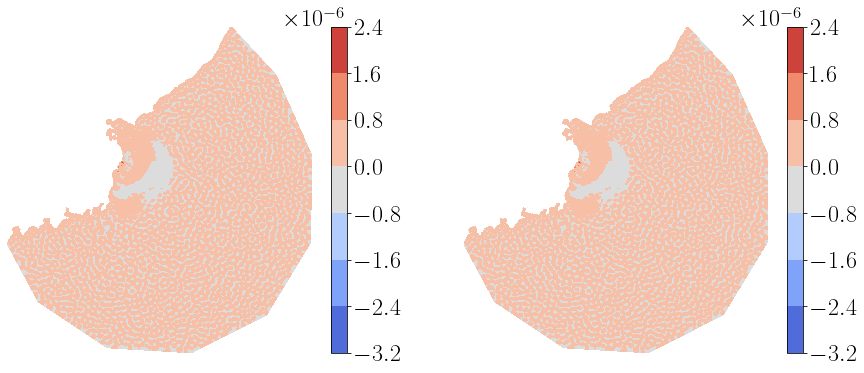

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
tc = tricontourf(zeta, axes=axes[0], cmap='coolwarm')
cb = plt.colorbar(tc, ax=axes[0])
axes[0].axis(False)
tc = tricontourf(disc_adj.split()[1], axes=axes[1], cmap='coolwarm')
cb = plt.colorbar(tc, ax=axes[1])
axes[1].axis(False);

In [ ]:
assert np.allclose(disc_adj.dat.data[1], cont_adj.dat.data[1])

Compute gradient using continuous adjoint method and check that it matches

In [29]:
gc = replace(L, {eta_: eta0, u_: u0, test_u: z, test_eta: zeta})
# gc += (1-theta)*dt*op.gauges[gauge]["indicator"]*(eta - op.gauges[gauge]["obs"])*zeta*dx
# gc += 0.5*(1-theta)*dt*op.gauges[gauge]["indicator"]*(eta0 - op.gauges[gauge]["obs_old"])**2*dx
gc10 = assemble(gc)
# assert np.isclose(gc10, gd10), f"{gc10} vs. {gd10}"

Sample control space at two more points and compute the discrete adjoint gradient at 5

In [30]:
J2 = Jhat(m.assign(2.0))
J5 = Jhat(m.assign(5.0))
gd5 = Jhat.derivative().dat.data[0]

In [31]:
# minconv = taylor_test(Jhat, Function(R).assign(5.0), Function(R).assign(0.1))
# assert minconv > 1.90, f"{minconv}"

Rerun the forward solver at 5

In [32]:
J = 0
adj_free = 0
u_.assign(0.0)
eta_.project(5*eta0)
solutions = [q_.copy(deepcopy=True)]
for i in range(num_timesteps):
    solver.solve()
    solutions.append(q.copy(deepcopy=True))
    for gauge in gauges:
        op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
        op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
    J = J + assemble(J_form)
    adj_free = adj_free + assemble(adj_free_form)
    q_.assign(q)
gaf5 = float(adj_free)/5
assert np.isclose(float(J), J5), f"{float(J)} vs. {J5}"

Compute the continuous adjoint gradient

In [33]:
w1.assign(1.0)
w2.assign(0.0)
cont_adj_.assign(0.0)
for i in range(num_timesteps-1, -1, -1):
    if i == num_timesteps-2:
        w2.assign(1.0)
    for gauge in gauges:
        op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
        op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
    q.assign(solutions[i+1])
    q_.assign(solutions[i])
    adj_solver.solve()
    cont_adj_.assign(cont_adj)
gc5 = assemble(gc)

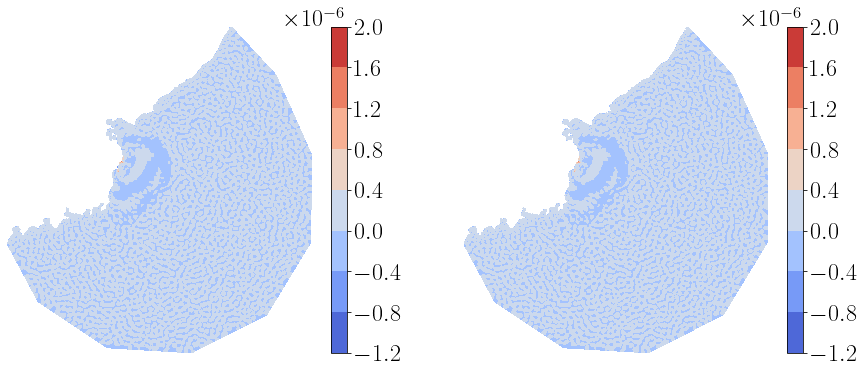

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
tc = tricontourf(zeta, axes=axes[0], cmap='coolwarm')
cb = plt.colorbar(tc, ax=axes[0])
axes[0].axis(False)
tc = tricontourf(solve_blocks[0].adj_sol.split()[1], axes=axes[1], cmap='coolwarm')
cb = plt.colorbar(tc, ax=axes[1])
axes[1].axis(False);

In [45]:
assert np.allclose(disc_adj.dat.data[1], cont_adj.dat.data[1])

In [35]:
l = si.lagrange([2, 5, 10], [J2, J5, J10])
dl = l.deriv()
l_min = -dl.coefficients[1]/dl.coefficients[0]
print("Minimiser of quadratic: {:.4f}".format(l_min))

Minimiser of quadratic: 4.0913


In [36]:
print(f"Exact gradient at 10              = {dl(10.0)}")
print(f"Discrete adjoint gradient at 10   = {gd10}")
print(f"Continuous adjoint gradient at 10 = {gc10}")
print(f"Adjoint-free gradient at 10       = {gaf10}")

Exact gradient at 10              = 2141.2075668043553
Discrete adjoint gradient at 10   = 2141.2075392191928
Continuous adjoint gradient at 10 = 2139.5127335699003
Adjoint-free gradient at 10       = 2141.2075722532327


In [37]:
print(f"Exact gradient at  5              = {dl(5.0)}")
print(f"Discrete adjoint gradient at 5    = {gd5}")
print(f"Continuous adjoint gradient at 5  = {gc5}")
print(f"Adjoint-free gradient at 5        = {gaf5}")

Exact gradient at  5              = 329.290049509744
Discrete adjoint gradient at 5    = 329.29003520339063
Continuous adjoint gradient at 5  = 328.8381195501612
Adjoint-free gradient at 5        = 329.2901139333871


### $m = 10$, $\theta=\frac12$

| Control | Exact | Discrete adjoint gradient | Continuous adjoint gradient | Adjoint-free gradient |
| --- | --- | --- | --- | --- |
| $\mathcal H_0$ | 2141.207639251425 | 2141.207581531595 | 2061.952074842359 | 2141.207638910488 |
| $\mathcal H_1$ | 526.1674328791948 | 526.1673905055596 | 519.3175327080207 | 526.1674328084456 |
| $\mathcal H_2$ | 103.2936469887949 | 103.29364695354961 | 100.81743611076712 | 103.29364699009201 |

Modified: 2139.5127758899093, 378.3037659915306, 103.14188628423766

### $m = 10$, $\theta=1$

| Control | Exact | Discrete adjoint gradient | Continuous adjoint gradient | Adjoint-free gradient |
| --- | --- | --- | --- | --- |
| $\mathcal H_0$ | 996.946711548131 | 996.9466818678358 | 996.9466789234594 | 996.9467112931563 |
| $\mathcal H_1$ | 377.8231655990096 | 377.82314762903945 | 377.8231455850006 | 377.8231656707512 |
| $\mathcal H_2$ | 111.544872299012 | 111.54487308411399 | 111.54486701689059 | 111.54487228213134 |

### $m=5$, $\theta=\frac12$

| Control | Exact | Discrete adjoint gradient | Continuous adjoint gradient | Adjoint-free gradient |
| --- | --- | --- | --- | --- |
| $\mathcal H_0$ | 329.2900712222381 | 329.290042780578 | 56.78621847257681 | 329.29009819835346 |
| $\mathcal H_1$ | 20.945296008141895 | 20.945293461478762 | -7.754552383889311 | 20.9452982768191622 |
| $\mathcal H_2$ | 1.5845813860534008 | 1.5845811897041913 | 6.223052320945998 | 1.5845838540562007 |

Modified: 328.83810740306126, -, -

### $m=5$, $\theta=1$

| Control | Exact | Discrete adjoint gradient | Continuous adjoint gradient | Adjoint-free gradient |
| --- | --- | --- | --- | --- |
| $\mathcal H_0$ | 84.64720043647787 | 84.64719576829249 | 84.64719576829249 | 84.64719576829249 |
| $\mathcal H_1$ | 11.212695995766921 | 11.212695689257226 | 11.212695466139648 | 11.212696813701077 |
| $\mathcal H_2$ | 1.4489872470329175 | 1.448986932869168 | 1.4489975420571772 | 1.4489978602280074 |

Plot the parameter space

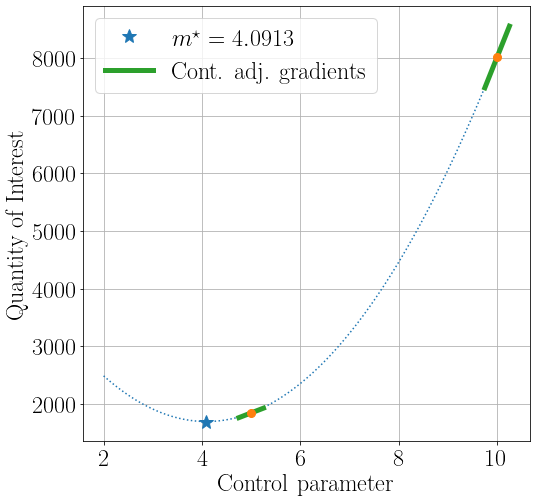

In [38]:
fig, axes = plt.subplots(figsize=(8, 8))
xx = np.linspace(2, 10, 100)
axes.plot(xx, l(xx), ':', color='C0')
axes.plot(l_min, l(l_min), '*', markersize=14, color='C0', label=r"$m^\star={:.4f}$".format(l_min))

delta_m = 0.25
m = [5.0, 10.0]
f = [J5, J10]
g = [gc5, gc10]
for i, (mi, fi, gi) in enumerate(zip(m, f, g)):
    x = np.array([mi - delta_m, mi + delta_m])
    axes.plot(x, gi*(x - mi) + fi, '-', color='C2', linewidth=5, label='Cont. adj. gradients' if i == 0 else None)
axes.plot(m, f, 'o', color='C1', markersize=8)

axes.set_xlabel("Control parameter")
axes.set_ylabel("Quantity of Interest")
axes.grid(True)
axes.legend();

Minimisers for $\theta=\frac12$: 4.0913, 4.7927, 4.9221.
Minimisers for $\theta=1$: 4.5361, 4.8471, 4.9342